In [1]:
import os

# Set datapath properly
path = os.getcwd() + "/data/"

if not os.path.exists(path):
  os.makedirs(path)

%env DATAPATH={path}

raw = 's.rsf'
raw_hfile = 's_hfile.rsf'
raw_tfile = 's_tfile.txt'
raw_bfile = 's_bfile.txt'
raw_deghost = "s_deghost.rsf"
raw_deghost_cdp = 's_deghost_cdp.rsf'
raw_deghost_gain = "s_deghost_gain.rsf"
raw_deghost_gain_cdp = "s_deghost_gain_cdp.rsf"
raw_deghost_gain_mute = "s_deghost_gain_mute.rsf"
raw_deghost_gain_mute_cdp = "s_deghost_gain_mute_cdp.rsf"
raw_deghost_gain_mute_dip = "s_deghost_gain_mute_dip.rsf"
raw_deghost_gain_mute_dip_cdp = "s_deghost_gain_mute_dip_cdp.rsf"
raw_deghost_gain_mute_dip_radon_cdp = "s_deghost_gain_mute_dip_radon_cdp.rsf"
vnmo_rsf = 'vnmo.rsf'
vnmow_rsf = 'vnmow.rsf'
sample = 'sample.rsf'
sample_deghost = 'sample_deghost.rsf'
sample_deghost_gain = 'sample_deghost_gain.rsf'
sample_deghost_gain_mute = 'sample_deghost_gain_mute.rsf'
sample_deghost_gain_mute_cdp = 'sample_deghost_gain_mute_cdp.rsf'
sample_deghost_gain_mute_dip = 'sample_deghost_gain_mute_dip.rsf'
sample_deghost_gain_mute_dip_cdp = 'sample_deghost_gain_mute_dip_cdp.rsf'
header_complete = 'sp_header_complete.rsf'
header_complete_int = 'sp_header_complete_int.rsf'
cdp_offsets = 'cdp_offsets.rsf'
sample_offsets = 'sample_cdp_offsets.rsf'
cdp_mask = "cdp_mask.rsf"
wavelet_file = os.getcwd() + "/../FarField.dat"

import numpy as np
import pandas as pd
from rsf.proj import *
import rsf.api as sf
import m8r
from m8r import view
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import periodogram, welch
from wiggle.wiggle import wiggle
import matplotlib
import matplotlib.PythonPlot as plt
from scipy.interpolate import griddata
from scipy.interpolate import Rbf

env: DATAPATH=/home/kerim/Documents/JUDI.jl/examples/field_examples/viking_graben_line12/proc/data/


Extract CDP sample

In [2]:
sample_deghost_gain_mute_dip_radon_cdp = 'sample_deghost_gain_mute_dip_radon_cdp.rsf'

cdp = 1000
!sfwindow f3={cdp} n3=1 < {raw_deghost_gain_mute_dip_radon_cdp} > {sample_deghost_gain_mute_dip_radon_cdp}
!sfintbin < {header_complete} head={header_complete_int} yk=cdp xk=cdpt | \
    sfwindow f3={cdp} n3=1 | \
    sfheadermath output='offset'/1000. > {sample_offsets}

sfintbin: 2142 of 2142;


Compare VelScans

sfvscan: cmp 1 of 1;
sfvscan: cmp 1 of 1;
sfpick: cmp 1 of 1;
sfpick: iteration 0 res: 1.000000 grad: 0.000000
sfpick: iteration 1 res: 0.517956 grad: 0.180019
sfpick: iteration 2 res: 0.322049 grad: 0.055061
sfpick: iteration 3 res: 0.189943 grad: 0.036097
sfpick: iteration 4 res: 0.098469 grad: 0.017670
sfpick: iteration 5 res: 0.058003 grad: 0.008050
sfpick: iteration 6 res: 0.035241 grad: 0.011199
sfpick: iteration 7 res: 0.026064 grad: 0.011528
sfpick: iteration 8 res: 0.016924 grad: 0.004611
sfpick: iteration 9 res: 0.009568 grad: 0.002788
sfpick: iteration 10 res: 0.004681 grad: 0.001102
sfpick: iteration 11 res: 0.002654 grad: 0.000456
sfpick: iteration 12 res: 0.002283 grad: 0.001440
sfpick: iteration 13 res: 0.001739 grad: 0.000294
sfpick: iteration 14 res: 0.001461 grad: 0.000452
sfpick: iteration 15 res: 0.000988 grad: 0.000152
sfpick: iteration 16 res: 0.000600 grad: 0.000158
sfpick: iteration 17 res: 0.000456 grad: 0.000081
sfpick: iteration 18 res: 0.000307 grad: 0.00009

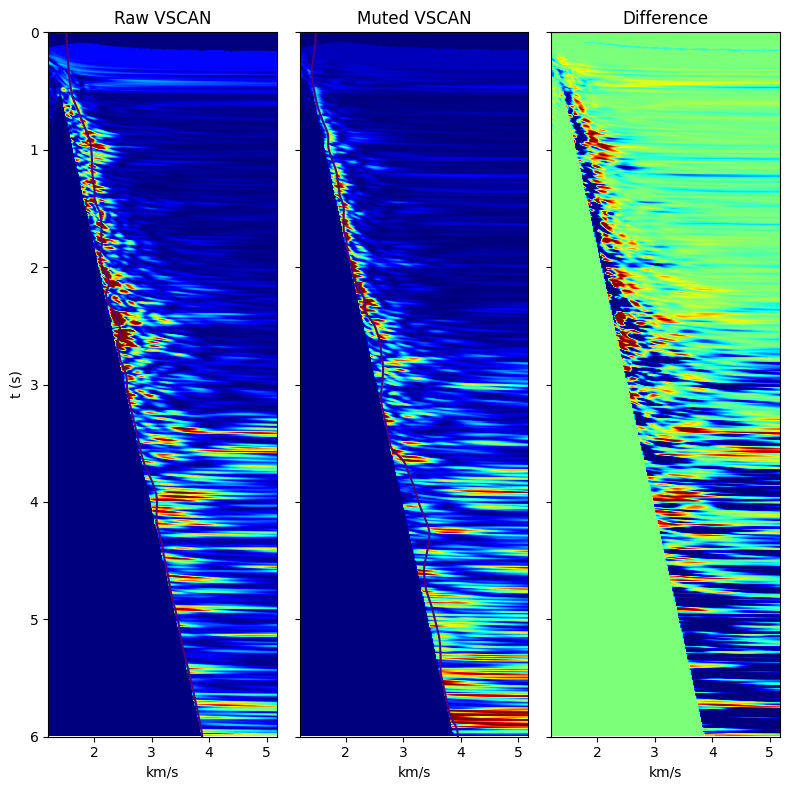

In [3]:
sample_vscan = "sample_deghost_gain_mute_dip_cdp_vscan.rsf"
sample_dip_vscan = "sample_deghost_gain_mute_dip_radon_cdp_vscan.rsf"

raw=sample_vscan
proc=sample_dip_vscan
raw_picks="sample_picks.rsf"
proc_picks="sample_picks_dip.rsf"

v0=1.2
dv=0.02
nv=200
nb=2
mute_x0=1.4
mute_v0=0.45
mute_t0=0.5
!sfvscan < {sample_deghost_gain_mute_dip_cdp} offset={sample_offsets} nb={nb} v0={v0} dv={dv} nv={nv} semblance=y half=n |\
    sfmutter inner=y x0={mute_x0} v0={mute_v0} t0={mute_t0} half=n > {raw}
!sfvscan < {sample_deghost_gain_mute_dip_radon_cdp} offset={sample_offsets} nb={nb} v0={v0} dv={dv} nv={nv} semblance=y half=n |\
    sfmutter inner=y x0={mute_x0} v0={mute_v0} t0={mute_t0} half=n > {proc}

rect1=15
rect2=5
vel0=1.5
!sfpick < {raw} rect1={rect1} rect2={rect2} vel0={vel0} back=y > {raw_picks}
!sfpick < {proc} rect1={rect1} rect2={rect2} vel0={vel0} back=y > {proc_picks}

# Load shot and visualize it
raw_in = sf.Input(raw)
d1 = raw_in.float('d1')

raw_arr = np.array(raw_in)
proc_arr = np.array(sf.Input(proc))
raw_picks_arr = np.array(sf.Input(raw_picks))
proc_picks_arr = np.array(sf.Input(proc_picks))
picks_list = [raw_picks_arr, proc_picks_arr]

t = np.arange(raw_arr.shape[1]) * d1
titles = ["Raw VSCAN", "Muted VSCAN", "Difference"]
plt.figure(figsize=(8,8))
for i, data in enumerate([raw_arr, proc_arr, raw_arr-proc_arr]):
    plt.subplot(1,3, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [v0, v0+dv*(nv-1), t[-1], t[0]]
    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='jet')
    if i == 0:
        plt.ylabel('t (s)')
    if i < 2:
        plt.plot(picks_list[i],t, color="Indigo")
    plt.xlabel('km/s')
    plt.title(titles[i])
    plt.ylim(6,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

Calculate picks for the whole dataset

In [4]:
vnmo_auto_rsf = "vnmo_auto.rsf"

!sfvscan < {raw_deghost_gain_mute_dip_radon_cdp} offset={cdp_offsets} \
  nb={nb} v0={v0} dv={dv} nv={nv} semblance=y half=n |\
  sfmutter inner=y x0={mute_x0} v0={mute_v0} t0={mute_t0} half=n |\
  sfpick rect1={rect1} rect1={rect2} back=y > {vnmo_auto_rsf}

sfpick: cmp 2142 of 2142;;

sfpick: iteration 0 res: 0.997407 grad: 0.000000
sfpick: iteration 1 res: 0.400842 grad: 0.379772
sfpick: iteration 2 res: 0.210689 grad: 0.164546
sfpick: iteration 3 res: 0.122373 grad: 0.085232
sfpick: iteration 4 res: 0.076046 grad: 0.049621
sfpick: iteration 5 res: 0.049592 grad: 0.031846
sfpick: iteration 6 res: 0.033454 grad: 0.020783
sfpick: iteration 7 res: 0.023297 grad: 0.014425
sfpick: iteration 8 res: 0.016692 grad: 0.010114
sfpick: iteration 9 res: 0.012257 grad: 0.007368
sfpick: iteration 10 res: 0.009186 grad: 0.005421
sfpick: iteration 11 res: 0.006973 grad: 0.004043
sfpick: iteration 12 res: 0.005378 grad: 0.003080
sfpick: iteration 13 res: 0.004195 grad: 0.002310
sfpick: iteration 14 res: 0.003284 grad: 0.001736
sfpick: iteration 15 res: 0.002598 grad: 0.001347
sfpick: iteration 16 res: 0.002074 grad: 0.001051
sfpick: iteration 17 res: 0.001664 grad: 0.000828
sfpick: iteration 18 res: 0.001346 grad: 0.000650
sfpick: iteration 19 res: 0.0010

Smooth auto picked velocity model

In [5]:
vnmo_auto_smooth_rsf = "vnmo_auto_smooth.rsf"
!sfsmooth < {vnmo_auto_rsf} rect1=1 rect2=50 repeat=3 > {vnmo_auto_smooth_rsf}

Visualize calculated Vel Model

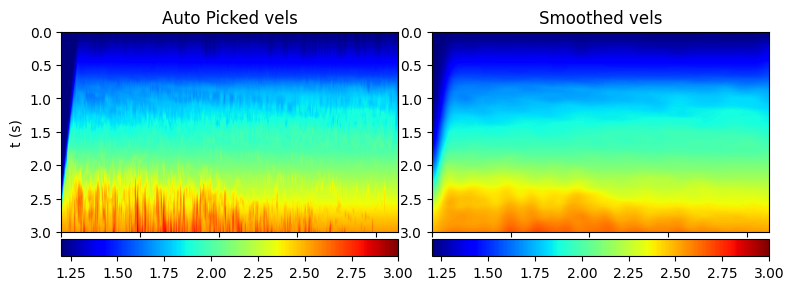

In [6]:
raw_stack = vnmo_auto_rsf
proc_stack = vnmo_auto_smooth_rsf

# Load vel models and visualize them
raw_stack_in = sf.Input(raw_stack)
proc_stack_in = sf.Input(proc_stack)

raw_stack_arr = np.array(raw_stack_in)
proc_stack__arr = np.array(proc_stack_in)

plt.figure(figsize=(8,3))
v_titles = ["Auto Picked vels", "Smoothed vels"]
for i, data in enumerate([raw_stack_arr, proc_stack__arr]):
    plt.subplot(1,2, i+1)
    extent = [0, data.shape[0], t[-1], t[0]]

    im=plt.imshow(data.T, aspect='auto', extent=extent,
              cmap='jet')
    plt.clim(1.2,3)
    plt.colorbar(im, orientation="horizontal", pad=0.03)
    if i == 0:
        plt.ylabel('t (s)')
    plt.xlabel('channel')

    plt.title(v_titles[i])
    plt.ylim(3,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

Compare stacks

sfnmo: CMP 2142 of 2142;
sfnmo: CMP 2142 of 2142;


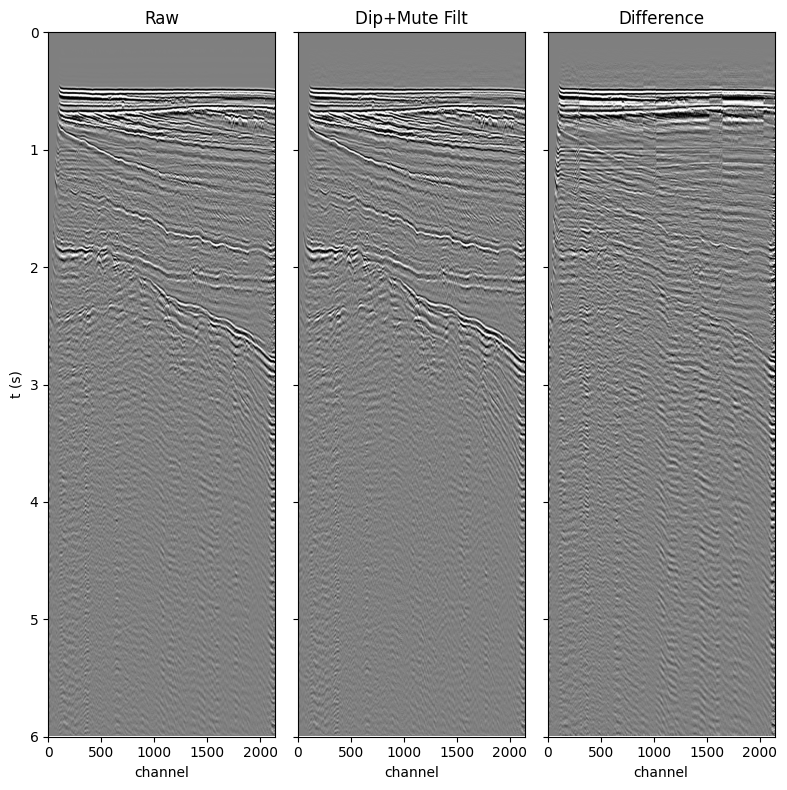

In [7]:
raw = raw_deghost_gain_mute_dip_cdp
proc = raw_deghost_gain_mute_dip_radon_cdp

raw_stack = 's_deghost_gain_mute_dip_cdp_stk.rsf'
proc_stack = 's_deghost_gain_mute_dip_radon_cdp_stk.rsf'

!sfnmo < {raw} velocity={vnmo_auto_smooth_rsf} offset={cdp_offsets} half=n | \
    sfstack > {raw_stack}

!sfnmo < {proc} velocity={vnmo_auto_smooth_rsf} offset={cdp_offsets} half=n | \
    sfstack > {proc_stack}

# Load stacks and visualize it
raw_stack_in = sf.Input(raw_stack)
proc_stack_in = sf.Input(proc_stack)

raw_stack_arr = np.array(raw_stack_in)
proc_stack__arr = np.array(proc_stack_in)

titles = ["Raw", "Dip+Mute Filt", "Difference"]
plt.figure(figsize=(8, 8))
for i, data in enumerate([raw_stack_arr, proc_stack__arr, raw_stack_arr-proc_stack__arr]):
    plt.subplot(1,3, i+1)
    perc = np.percentile(data.ravel(), 99)
    extent = [0, data.shape[0], t[-1], t[0]]

    plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent,
              cmap='gray_r')
    if i == 0:
        plt.ylabel('t (s)')
    plt.xlabel('channel')

    plt.title(titles[i])
    plt.ylim(6,0)

for ax in plt.gcf().axes:
    try:
        ax.label_outer()
    except:
        pass
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)